### Figure generation notebook for Visium bulk comparisons with MERFISH

**Description**
This notebook is to generate SI figures for the comparison of Visium (public datasets) and MERFISH spatial transcriptomics datasets using mouse liver and kidney samples. The idea is to replicate the Figure 3 in the main text (which was done for MERFISH and scRNA-seq) for different spatial transcriptomics technology (Visium, sequencing-based) to see how much correlation we'd expect between spatial transcriptomics technologies and MERFISH.

**Resources (Public Visium datasets)**
- mouse liver: https://zenodo.org/record/4399655#.Yts9ei-B0rZ (total of 12 datasets)
- mouse kidney: https://www.rebuildingakidney.org/chaise/record/#2/Common:Collection/RID=17-E9J6 (1 dataset, "sham" which was used as a Control in https://jasn.asnjournals.org/content/33/2/279 paper.)

In [21]:
import os
import sys
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
import numpy as np
import anndata as ad
import scanpy as sc
import string
import seaborn as sns


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none') 

# load the sc-utilities
sys.path.append("/home/yangjoon.kim/single-cell-utilities/spatial/")
import convert_pipeline_outputs_h5ad

### Mouse liver

This repository contains original data such as count matrices, spot coordinate files, Hematoxylin & Eosin stained images, vein-masks, etc. Sample 1 to sample 3 refers to the individual ST experiments performed in this study. Sample 1 consists of 3 sections of the murine caudate lobe. Sample 2 consists of 4 sections of the right lobe, of which to were excluded for analysis. Sample 3 consists of 5 sections of the caudate lobe, of which two were excluded for analysis. These folders contain input data for the R markdown script, which can be found in this GitHub repository: https://github.com/almaan/ST-mLiver. 

Note. The number of genes per dataset is different, some datsets have 9K, whereas the rest has 8.8K. Not a huge difference, but we will just use the subset of genes as we will get averaged transcript counts per gene across all datasets.

In [131]:
# Load the public visium datasets 
# mouse liver (8-12 weeks old) - 12 datasets, totalling ~8K "Spots" after QC
visium_liver_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/liver/h5ad-cca/"
h5ad_list = os.listdir(visium_liver_path)
h5ad_list

visium_liver = sc.read_h5ad(visium_liver_path+h5ad_list[0])
visium_liver

for name in h5ad_list[1:]:
    # read the new h5ad file
    adata_temp = sc.read_h5ad(visium_liver_path+name)
    visium_liver = visium_liver.concatenate(adata_temp, join="outer")

visium_liver


AnnData object with n_obs × n_vars = 8746 × 9655
    obs: '_x', '_y', 'x', 'y', 'sample', 'replicate', 'batch'
    var: 'gene'
    obsm: 'vein_distances'

In [29]:
# check how large is one dataset
visium_liver_0 = sc.read_h5ad(visium_liver_path+h5ad_list[0])
visium_liver_0

AnnData object with n_obs × n_vars = 629 × 9655
    obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
    var: 'gene'
    uns: 'img', 'mask', 'replicate', 'sample'
    obsm: 'vein_distances'

In [132]:
visium_liver.obs

,_x,_y,x,y,sample,replicate,batch
2x38-0-0-0-0-0-0-0-0-0-0-0,2,38,506.890,1746.490,CN65,D2,0
2x40-0-0-0-0-0-0-0-0-0-0-0,2,40,505.470,1825.800,CN65,D2,0
2x42-0-0-0-0-0-0-0-0-0-0-0,2,42,505.620,1907.030,CN65,D2,0
2x44-0-0-0-0-0-0-0-0-0-0-0,2,44,506.230,1986.670,CN65,D2,0
3x39-0-0-0-0-0-0-0-0-0-0-0,3,39,544.140,1785.660,CN65,D2,0
...,...,...,...,...,...,...,...
65x31-1,65,31,2749.923,1218.855,CN65,C2,1
65x33-1,65,33,2750.484,1298.880,CN65,C2,1
65x35-1,65,35,2749.692,1378.113,CN65,C2,1
65x37-1,65,37,2752.893,1456.587,CN65,C2,1


In [112]:
np.sum(np.expm1(visium_liver.X),1)

array([6509., 7276., 7287., ..., 7317., 7306., 7249.], dtype=float32)

This visium dataset seems to be log-normalized (from the recovery using np.expm1).

For convenience, we will just revert the log-normalization (using np.expm1(adata.X)), and sum over all cells (Spots) so that we can average the counts over replicates (across 12 Visium datasets).

### Compute the pseudo-bulk transcript counts for all genes per sample


In [159]:
sample = list_samples[0]
replicate = list_replicates[0]

subset = visium_liver[(visium_liver.obs["sample"]==sample)&(visium_liver.obs["replicate"]==replicate)]
df_temp = pd.DataFrame(np.expm1(subset.X),columns=subset.var_names)
df_temp

pseudo_bulk_counts_perGene = pd.DataFrame()
pseudo_bulk_counts_perGene.loc[:,sample+"_"+replicate] = np.sum(df_temp,0)
pseudo_bulk_counts_perGene

,CN65_D2
Mrpl15,464.0
Lypla1,1129.0
Tcea1,33.0
Atp6v1h,290.0
Rb1cc1,126.0
...,...
Xlr3a,21.0
Zxdb,19.0
Armcx2,26.0
Trappc2,23.0


In [160]:
# we have "sample" and "replicate" for dataset IDs
list_samples = visium_liver.obs["sample"].unique()
list_samples

list_replicates = visium_liver.obs["replicate"].unique()
list_replicates

# define a dataframe to save the result (pseudo-bulk counts per gene)
pseudo_bulk_counts_perGene = pd.DataFrame()

for sample in list_samples:
    for replicate in list_replicates:
        subset = visium_liver[(visium_liver.obs["sample"]==sample)&(visium_liver.obs["replicate"]==replicate)]
        # convert the log-norm counts to "raw" counts
        df_temp = pd.DataFrame(np.expm1(subset.X),columns=subset.var_names)
        # compute the pseudo-bulk counts per gene (across ALL Spots)
        pseudo_bulk_counts_perGene.loc[:,sample+"_"+replicate] = np.sum(df_temp,0)

pseudo_bulk_counts_perGene

,CN65_D2,CN65_E1,CN65_D1,CN65_C1,CN65_E2,CN65_C2,CN16_D2,CN16_E1,CN16_D1,CN16_C1,CN16_E2,CN16_C2,CN73_D2,CN73_E1,CN73_D1,CN73_C1,CN73_E2,CN73_C2
Mrpl15,464.0,449.0,474.0,415.0,0.0,526.0,335.0,757.0,801.0,0.0,329.0,0.0,0.0,0.0,553.0,544.0,542.0,0.0
Lypla1,1129.0,1178.0,1321.0,1237.0,0.0,1220.0,833.0,1589.0,1214.0,0.0,593.0,0.0,0.0,0.0,1364.0,1426.0,1289.0,0.0
Tcea1,33.0,34.0,33.0,16.0,0.0,16.0,33.0,21.0,34.0,0.0,26.0,0.0,0.0,0.0,37.0,54.0,66.0,0.0
Atp6v1h,290.0,267.0,341.0,256.0,0.0,293.0,244.0,417.0,417.0,0.0,181.0,0.0,0.0,0.0,221.0,217.0,258.0,0.0
Rb1cc1,126.0,117.0,121.0,82.0,0.0,135.0,291.0,122.0,238.0,0.0,131.0,0.0,0.0,0.0,158.0,275.0,226.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xlr3a,21.0,12.0,38.0,13.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zxdb,19.0,25.0,25.0,12.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armcx2,26.0,23.0,27.0,11.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trappc2,23.0,24.0,22.0,27.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# we need to get a subset of genes that are present in both this Visium dataset and the MACA dataset
pseudo_bulk_counts_perGene.index

Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1', 'Gm24276',
       'Rrs1', 'Adhfe1', 'Vcpip1',
       ...
       'Aph1b', 'Gm10642', 'Plscr1', 'Cdcp1', 'Nkrf', 'Xlr3a', 'Zxdb',
       'Armcx2', 'Trappc2', 'Erdr1'],
      dtype='object', length=9655)

In [164]:
pseudo_bulk_counts_perGene_liver = np.mean(pseudo_bulk_counts_perGene,1)
pseudo_bulk_counts_perGene_liver

Mrpl15     343.833333
Lypla1     799.611111
Tcea1       22.388889
Atp6v1h    189.000000
Rb1cc1     112.333333
              ...    
Xlr3a        6.444444
Zxdb         5.888889
Armcx2       5.888889
Trappc2      6.333333
Erdr1       15.666667
Length: 9655, dtype: float64

### recovery of spatial coordinates (sanity check)

In [43]:
# recovering the spatial coordinates (we should do this for each dataset if we want to recover the spatial info)
spatial_coord = list(zip(visium_liver_0.obs["x"], visium_liver_0.obs["y"]))
spatial_coord

[(506.89, 1746.4900000000002),
 (505.47, 1825.8000000000002),
 (505.62, 1907.03),
 (506.23, 1986.67),
 (544.14, 1785.6599999999999),
 (542.87, 1866.6900000000003),
 (543.46, 1946.31),
 (543.0, 2026.61),
 (580.36, 1745.6900000000003),
 (578.3000000000001, 1826.21),
 (578.37, 1907.2200000000003),
 (579.59, 1986.6200000000001),
 (579.62, 2066.43),
 (615.08, 1785.7400000000002),
 (614.57, 1866.8200000000002),
 (614.04, 1946.6400000000003),
 (614.79, 2025.6900000000003),
 (615.59, 2105.81),
 (650.4200000000001, 1745.7200000000003),
 (648.02, 1825.8500000000001),
 (648.69, 1907.08),
 (648.9000000000001, 1986.7400000000002),
 (649.48, 2066.18),
 (648.45, 2146.36),
 (686.6, 1786.31),
 (683.69, 1866.4400000000003),
 (684.5600000000001, 1946.2700000000002),
 (685.14, 2026.4),
 (685.33, 2106.3700000000003),
 (722.29, 1746.2400000000002),
 (720.14, 1827.0200000000002),
 (720.6600000000001, 1908.4),
 (720.85, 1987.13),
 (720.9100000000001, 2067.25),
 (719.7600000000001, 2147.57),
 (758.300000000000

In [56]:
spatial_coord = np.asarray(spatial_coord)
visium_liver_0.obsm["spatial"] = spatial_coord

In [95]:
sc.pp.calculate_qc_metrics(visium_liver_0, inplace=True)

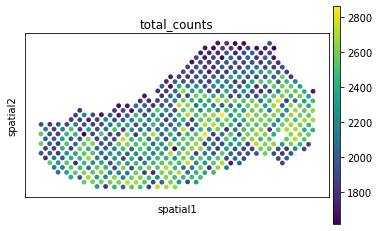

In [96]:
sc.pl.spatial(visium_liver_0,color="total_counts", spot_size=40)

### Mouse kidney

In [25]:
# mouse kidney (8-10 weeks old)
visium_kidney_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/fsham_137_processed/outs/"
output_dir = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/"
visium_kidney =  convert_pipeline_outputs_h5ad.convert_visium_output_to_h5ad(visium_kidney_path, output_dir, option=False)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


In [26]:
visium_kidney

AnnData object with n_obs × n_vars = 1617 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'X_spatial'

In [51]:
visium_kidney.obsm["spatial"]

array([[6710, 7863],
       [5706, 2806],
       [6907, 3753],
       ...,
       [3587, 5292],
       [4429, 6174],
       [6063, 2734]])

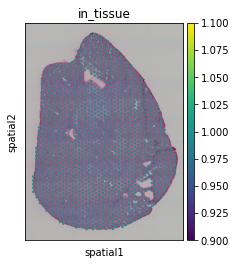

In [27]:
sc.pl.spatial(visium_kidney, color="in_tissue")

In [67]:
# check if the adata.X is raw counts
np.sum(visium_kidney.X.todense(),1)

matrix([[ 5855.],
        [ 6619.],
        [ 3675.],
        ...,
        [ 6011.],
        [13049.],
        [ 3692.]], dtype=float32)

In [170]:
df_counts = pd.DataFrame(visium_kidney.X.todense(),
                         columns = visium_kidney.var_names)
df_counts

pseudo_bulk_counts_perGene_kidney = np.sum(df_counts)
pseudo_bulk_counts_perGene_kidney


Xkr4            0.0
Gm1992          0.0
Gm19938         0.0
Gm37381         0.0
Rp1             1.0
              ...  
AC124606.1      0.0
AC133095.2      0.0
AC133095.1      0.0
AC234645.1      0.0
AC149090.1    631.0
Length: 32285, dtype: float32

In [182]:
# just out of curiosity, compute the number of genes which have at least one count across all cells
pseudo_bulk_counts_perGene_kidney[pseudo_bulk_counts_perGene_kidney!=0]

Rp1                  1.0
Sox17              129.0
Gm37587              1.0
Mrpl15             725.0
Lypla1            2188.0
                   ...  
Vamp7              252.0
Spry3                4.0
Tmlhe               32.0
CAAA01147332.1       1.0
AC149090.1         631.0
Length: 17686, dtype: float32

(array([3.0998e+04, 6.7700e+02, 1.9700e+02, 9.2000e+01, 6.9000e+01,
        4.6000e+01, 2.4000e+01, 3.1000e+01, 2.9000e+01, 1.8000e+01,
        1.2000e+01, 1.3000e+01, 9.0000e+00, 1.4000e+01, 6.0000e+00,
        4.0000e+00, 6.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

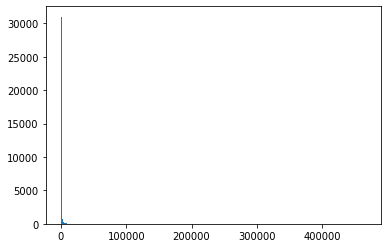

In [180]:
counts_sum = pseudo_bulk_counts_perGene_kidney.values
plt.hist(counts_sum, bins=300)

# Most of the counts are zeros.

## Load the MACA datasets as well as Vizgen datasets

In [264]:
# Load data
dataPath = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults/BulkCounts'

experimentNames = ['Msliver_VZG116_021121',
                   'Msliver_VZG116_021221',
                   'Msliver_VZG116_021621',
                   'Msliver_VZG116_021721',
                   'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021',
                   'MsKidney_CellBoundary_VZG116_111921',
                   'MsKidney_CellBoundary_VZG116_121021']
bulkCounts = []

for i in range(len(experimentNames)):
    bulkCounts.append(pd.read_csv(os.path.join(
    dataPath, experimentNames[i] + '_BulkRNACounts.csv')))

print('Bulk RNA counts loaded.')

# MACA data
MACA = pd.read_csv('/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/TabulaMurisSenis/190214_A00111_0269_AHH3J3DSXX__190214_A00111_0270_BHHMFWDSXX.csv',
                  index_col=0)
MACA_meta = pd.read_csv('/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/TabulaMurisSenis/MACA_Bulk_metadata.csv')

# Use only mice that are 18 months or younger
#ages = ['6','3','18','1','12','9','15']
ages = ['3'] # Use only 3 month old mice
ind = MACA_meta['characteristics: age'].isin(ages)
samplesToKeep = MACA_meta['Sample name'][ind]
samplesToKeep = [s + '.gencode.vM19' for s in samplesToKeep] # Append the suffix to get the sample names consistent

MACA = MACA.loc[:, samplesToKeep]
MACA_meta = MACA_meta.loc[ind]
print('MACA results loaded.')

Bulk RNA counts loaded.
MACA results loaded.


### Panel A and B: replicate comparisons in MERFISH liver and kidney

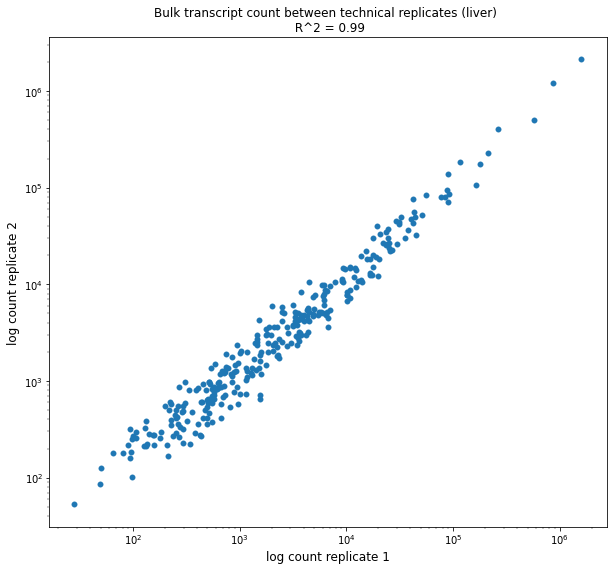

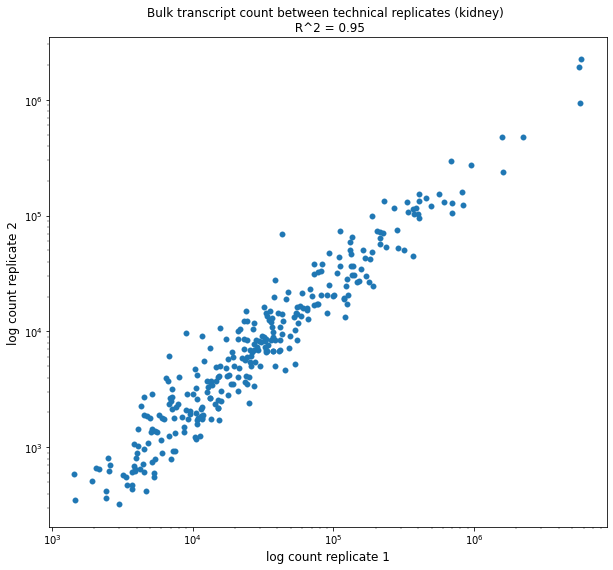

In [265]:
# Update this once we have multiple replicates


VizgenCountsLiver = []
VizgenCountsKidney = []

liver_ind = [0,1,2,3,4] # Indices of liver experiments
kidney_ind = [5,6] # Indices of kidney experiments

for i in liver_ind:
    VizgenCountsLiver.append(bulkCounts[i])
    
for i in kidney_ind:
    VizgenCountsKidney.append(bulkCounts[i])




# Look at correlation between Vizgen replicates

# Liver

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_liver = np.corrcoef(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
R2_reps_liver = R2_reps_liver[1,0]

plt.figure()
plt.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (liver) \n R^2 = ' + str(round(R2_reps_liver,2)))
plt.show()

# Kidney

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_kidney = np.corrcoef(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
R2_reps_kidney = R2_reps_kidney[1,0]

plt.figure()
plt.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (kidney) \n R^2 = ' + str(round(R2_reps_kidney,2)))
plt.show()

### extra Panel : correlation between Visium and MACA bulk RNA-seq (mouse liver)

In [189]:
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

mrpl15     343.833333
lypla1     799.611111
tcea1       22.388889
atp6v1h    189.000000
rb1cc1     112.333333
              ...    
xlr3a        6.444444
zxdb         5.888889
armcx2       5.888889
trappc2      6.333333
erdr1       15.666667
Length: 9655, dtype: float64

In [196]:
#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

In [201]:
pseudo_bulk_counts_perGene_liver

mrpl15     343.833333
lypla1     799.611111
tcea1       22.388889
atp6v1h    189.000000
rb1cc1     112.333333
              ...    
xlr3a        6.444444
zxdb         5.888889
armcx2       5.888889
trappc2      6.333333
erdr1       15.666667
Length: 9655, dtype: float64

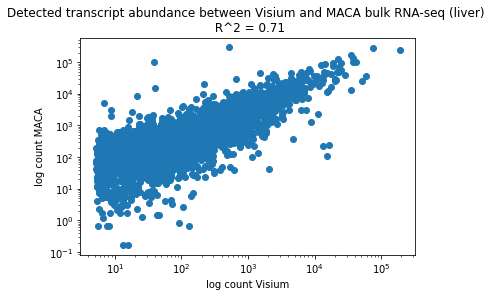

In [239]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsLiver[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list

# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

MACA_counts_perGene_liver = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates
# VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
#                                           for i in range(len(VizgenCountsLiver))]),
#                                          columns=[experimentNames[x] for x in liver_ind])
# VizgenLiver['average'] = VizgenLiver.mean(axis=1)
# VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_liver

# make the gene names as lower case
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

df_visium_liver = pd.DataFrame(pseudo_bulk_counts_perGene_liver)
df_visium_liver = df_visium_liver.rename(columns={0:"average"})
df_visium_liver["gene"] = df_visium_liver.index
df_visium_liver

# Rename Vizgen genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
# rename_map = {'faim3':'fcmr',
#               'mir205hg':'4631405k08rik',
#              'tmem27':'cltrn',
#              'gpr116':'adgrf5',
#              'emr1':'adgre1',
#              'cybasc3':'cyb561a3',
#              'ptrf':'cavin1',
#              'fam159b':'shisal2b',
#              '1700011h14rik':'ccdc198'}
# for i in range(VizgenLiver.shape[0]):
#     if VizgenLiver.loc[i,'gene'] in rename_map.keys():
#         VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

# Get the intersection_liver with common genes
intersection_liver = df_visium_liver[['average','gene']].merge(MACA_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Visium_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = np.corrcoef(intersection_liver['Visium_avg'], intersection_liver['MACA_avg'])
R2_compare_liver = R2_compare_liver[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Visium_avg'], intersection_liver['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Visium')
plt.ylabel('log count MACA')
plt.title('Detected transcript abundance between Visium and MACA bulk RNA-seq (liver) \n R^2 = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

In [240]:
intersection_liver

,Visium_avg,gene,MACA_avg
0,343.833333,mrpl15,602.500000
1,799.611111,lypla1,3523.666667
2,22.388889,tcea1,434.166667
3,189.000000,atp6v1h,850.500000
4,112.333333,rb1cc1,772.000000
...,...,...,...
9294,5.888889,nkrf,14.833333
9295,6.444444,xlr3a,163.666667
9296,5.888889,zxdb,21.833333
9297,5.888889,armcx2,40.333333


### extra Panel : correlation between Visium and MACA bulk RNA-seq (mouse kidney)

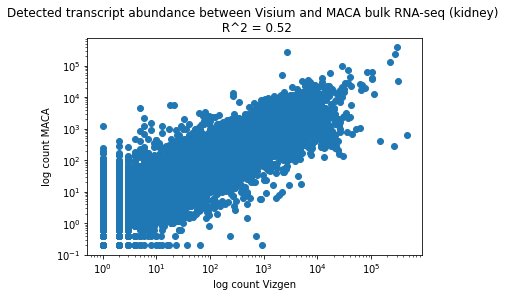

In [243]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsKidney[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list
# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are kidney tissue
kidney_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Kidney')] #Plates containing kidney experiments
kidney_plate_strings = kidney_plates.to_list() #Convert to list of strings
kidney_plate_strings = [s + '.gencode.vM19' for s in kidney_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are kidney tissue (reset gene column from index)
MACA_kidney = MACA.copy()[kidney_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes
#First, make gene list lower case
MACA_kidney['gene'] = MACA_kidney['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_kidney['average'] = MACA_kidney.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

#VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
#                                          for i in range(len(VizgenCountsKidney))]),
#                                         columns=[experimentNames[x] for x in kidney_ind])
#VizgenKidney['average'] = VizgenKidney.mean(axis=1)
#VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
# for i in range(VizgenKidney.shape[0]):
#     if VizgenKidney.loc[i,'gene'] in rename_map.keys():
#         VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]


# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_kidney

# make the gene names as lower case
pseudo_bulk_counts_perGene_kidney.index = pseudo_bulk_counts_perGene_kidney.index.str.lower()
pseudo_bulk_counts_perGene_kidney

df_visium_kidney = pd.DataFrame(pseudo_bulk_counts_perGene_kidney)
df_visium_kidney = df_visium_kidney.rename(columns={0:"average"})
df_visium_kidney["gene"] = df_visium_kidney.index
df_visium_kidney



# Get the intersection_kidney with common genes
intersection_kidney = df_visium_kidney[['average','gene']].merge(MACA_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Visium_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = np.corrcoef(intersection_kidney['Visium_avg'], intersection_kidney['MACA_avg'])
R2_compare_kidney = R2_compare_kidney[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Visium_avg'], intersection_kidney['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('Detected transcript abundance between Visium and MACA bulk RNA-seq (kidney) \n R^2 = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

### Panel C: correlation between Visium and MERFISH (Vizgen) - Mouse liver


In [267]:
VizgenCountsLiver[0]['gene']

0         PTPRC
1        PECAM1
2           KDR
3          CDH5
4          CD19
         ...   
302         LUM
303    SERPINF1
304    CRISPLD2
305       HTRA3
306       AEBP1
Name: gene, Length: 307, dtype: object

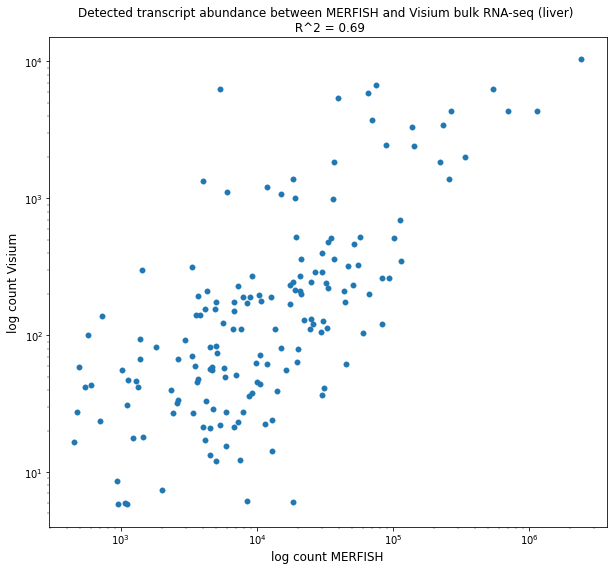

In [268]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsLiver[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list

gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates
VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
                                          for i in range(len(VizgenCountsLiver))]),
                                         columns=[experimentNames[x] for x in liver_ind])
VizgenLiver['average'] = VizgenLiver.mean(axis=1)
VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_liver

# make the gene names as lower case
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

df_visium_liver = pd.DataFrame(pseudo_bulk_counts_perGene_liver)
df_visium_liver = df_visium_liver.rename(columns={0:"average"})
df_visium_liver["gene"] = df_visium_liver.index
df_visium_liver

# Rename Vizgen genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
rename_map = {'faim3':'fcmr',
              'mir205hg':'4631405k08rik',
             'tmem27':'cltrn',
             'gpr116':'adgrf5',
             'emr1':'adgre1',
             'cybasc3':'cyb561a3',
             'ptrf':'cavin1',
             'fam159b':'shisal2b',
             '1700011h14rik':'ccdc198'}
for i in range(VizgenLiver.shape[0]):
    if VizgenLiver.loc[i,'gene'] in rename_map.keys():
        VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

# Get the intersection_liver with common genes
intersection_liver = VizgenLiver[['average','gene']].merge(df_visium_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = np.corrcoef(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
R2_compare_liver = R2_compare_liver[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count MERFISH')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between MERFISH and Visium bulk RNA-seq (liver) \n R^2 = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

In [272]:
VizgenLiver

,Msliver_VZG116_021121,Msliver_VZG116_021221,Msliver_VZG116_021621,Msliver_VZG116_021721,MsLiver_Cellbound_VZG116_V1_JH_09-18-2021,average,gene
0,1774.0,1472.0,801.0,4859.0,4235.0,2628.2,ptprc
1,1403.0,2475.0,1335.0,6544.0,4967.0,3344.8,pecam1
2,307.0,973.0,736.0,4583.0,18355.0,4990.8,kdr
3,748.0,1881.0,1317.0,4386.0,12254.0,4117.2,cdh5
4,12327.0,14197.0,11762.0,39666.0,3308.0,16252.0,cd19
...,...,...,...,...,...,...,...
302,108.0,256.0,174.0,647.0,1668.0,570.6,lum
303,19371.0,39894.0,18105.0,77038.0,558014.0,142484.4,serpinf1
304,2354.0,2708.0,1612.0,4851.0,1994.0,2703.8,crispld2
305,1589.0,2007.0,1272.0,3539.0,2498.0,2181.0,htra3


In [270]:
df_visium_liver

,average,gene
mrpl15,343.833333,mrpl15
lypla1,799.611111,lypla1
tcea1,22.388889,tcea1
atp6v1h,189.000000,atp6v1h
rb1cc1,112.333333,rb1cc1
...,...,...
xlr3a,6.444444,xlr3a
zxdb,5.888889,zxdb
armcx2,5.888889,armcx2
trappc2,6.333333,trappc2


**Note** 

The number of genes in Vizgen/MERFISH dataset is 307, and Visium dataset is 9655. However, after getting the joint subset, only 165 genes are left. We probably need to double check whether there was any inconsistency in gene names between Visium dataset and Vizgen/MERFISH datasets.

In [288]:
list(set(VizgenLiver["gene"]) - set(df_visium_liver["gene"]))

['cd8a',
 'ccr2',
 'bcl11a',
 'ramp3',
 'chgb',
 'h2-ab1',
 'des',
 'cd34',
 'mfap5',
 'cd3g',
 'muc4',
 'h2-aa',
 'cpa1',
 'scg2',
 'pdx1',
 'ptprn2',
 'ppp1r1a',
 'pcsk1n',
 'kcnk16',
 'mal',
 'klra2',
 'pcsk2',
 'lsp1',
 'txk',
 'sfrp5',
 'rnase6',
 'nkx6-1',
 'cd8b1',
 'pappa2',
 'tspan8',
 'klrb1f',
 'krt7',
 'bank1',
 'elane',
 'itgax',
 'gzmb',
 'cd79b',
 'neurog3',
 'cyb561a3',
 'cavin1',
 'sele',
 'fcmr',
 '4631405k08rik',
 'ms4a1',
 'krt5',
 'cd6',
 'gzmk',
 'kcnj1',
 'pnliprp2',
 'hdc',
 'ptgis',
 'mmp9',
 'scg3',
 'derl3',
 'ctsw',
 'apold1',
 'cd247',
 'cd3d',
 'trat1',
 's100a14',
 'chga',
 'klrb1c',
 'synpo',
 'cpe',
 'igfbp6',
 'foxc1',
 'cd37',
 'cd4',
 'cd79a',
 'lck',
 'pglyrp1',
 'pnliprp1',
 'il2rb',
 'jchain',
 'cd19',
 'scg5',
 'notch3',
 'wt1',
 'tlr7',
 'ccdc198',
 'g6pc2',
 'wdr72',
 'cltrn',
 'ms4a6b',
 'cldn7',
 'sox17',
 'cxcr6',
 'krt19',
 'spib',
 'adamts9',
 'slc30a8',
 'alox5ap',
 'selplg',
 'kcne1',
 'ism1',
 'aqp2',
 'cd22',
 'ace2',
 'htra3',
 'dcdc2

In [283]:
# rename_map = {'faim3':'fcmr',
#               'mir205hg':'4631405k08rik',
#              'tmem27':'cltrn',
#              'gpr116':'adgrf5',
#              'emr1':'adgre1',
#              'cybasc3':'cyb561a3',
#              'ptrf':'cavin1',
#              'fam159b':'shisal2b',
#              '1700011h14rik':'ccdc198'}
df_visium_liver[df_visium_liver["gene"]=="gpr116"]

,average,gene


In [269]:
intersection_liver

,Vizgen_avg,gene,Visium_avg
0,2628.2,ptprc,33.666667
1,3344.8,pecam1,70.833333
2,4990.8,kdr,174.777778
3,4117.2,cdh5,155.166667
4,4689.8,cnksr3,58.555556
...,...,...,...
160,11430.6,pdgfrb,22.500000
161,12904.0,pcolce,23.944444
162,6764.6,gsn,175.000000
163,570.6,lum,101.111111


### Panel D: correlation between MERFISH and Visium (mouse kidney)


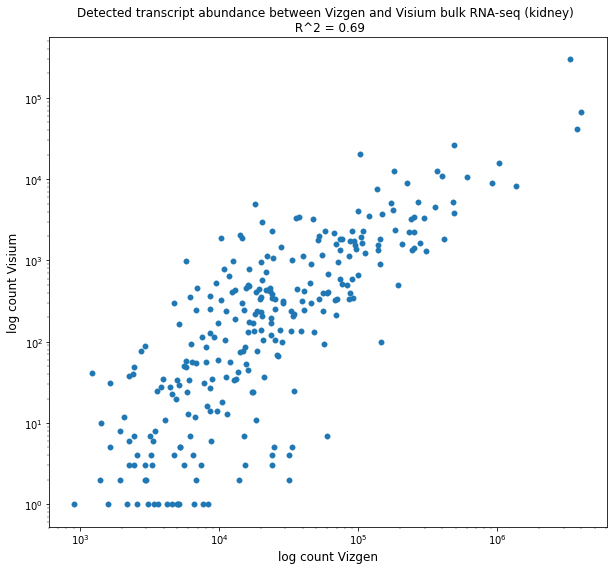

In [294]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsKidney[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list
gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates

VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
                                         for i in range(len(VizgenCountsKidney))]),
                                        columns=[experimentNames[x] for x in kidney_ind])
VizgenKidney['average'] = VizgenKidney.mean(axis=1)
VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
for i in range(VizgenKidney.shape[0]):
    if VizgenKidney.loc[i,'gene'] in rename_map.keys():
        VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]


# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_kidney

# make the gene names as lower case
pseudo_bulk_counts_perGene_kidney.index = pseudo_bulk_counts_perGene_kidney.index.str.lower()
pseudo_bulk_counts_perGene_kidney

df_visium_kidney = pd.DataFrame(pseudo_bulk_counts_perGene_kidney)
df_visium_kidney = df_visium_kidney.rename(columns={0:"average"})
df_visium_kidney["gene"] = df_visium_kidney.index
df_visium_kidney



# Get the intersection_kidney with common genes
intersection_kidney = VizgenKidney[['average','gene']].merge(df_visium_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = np.corrcoef(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
R2_compare_kidney = R2_compare_kidney[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between Vizgen and Visium bulk RNA-seq (kidney) \n R^2 = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

In [295]:
intersection_kidney

,Vizgen_avg,gene,Visium_avg
0,5798.5,ptprc,58.0
1,11753.0,pecam1,648.0
2,100120.5,kdr,664.0
3,70346.5,cdh5,338.0
4,8364.0,cd19,1.0
...,...,...,...
301,2729.5,lum,77.0
302,6802.5,serpinf1,55.0
303,28700.5,crispld2,296.0
304,8847.5,htra3,35.0


### Panel E: histogram of ratio of counts per gene in liver (averaged across experiments)

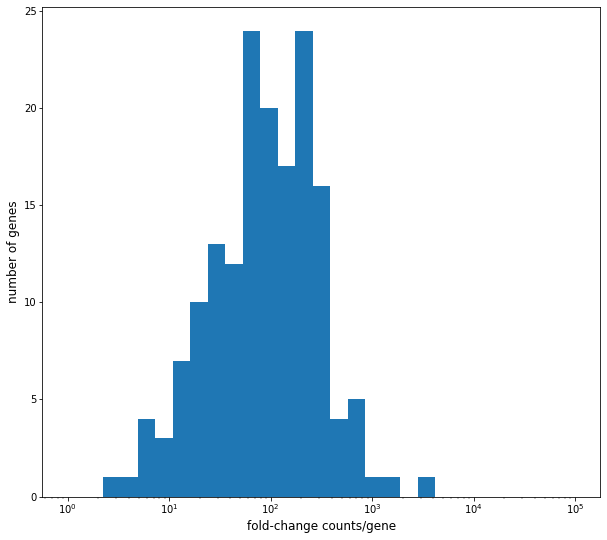

In [296]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_liver['Vizgen_avg'] / intersection_liver['Visium_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

### Panel F: histogram of counts per gene in kidney (averaged across experiments)

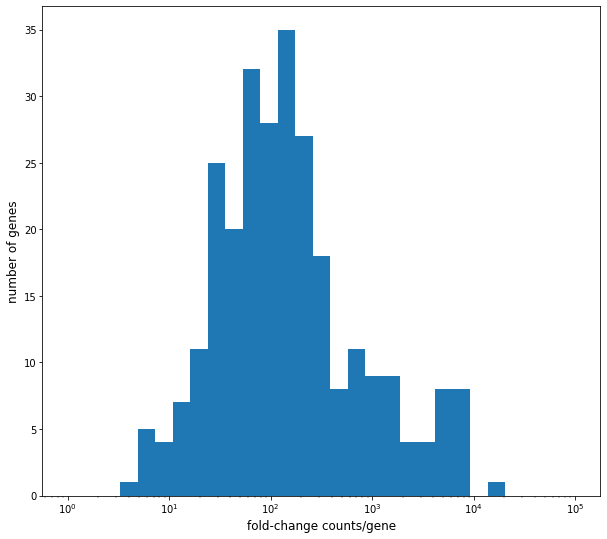

In [297]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['Visium_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

In [301]:
intersection_liver

,Vizgen_avg,gene,Visium_avg
0,2628.2,ptprc,33.666667
1,3344.8,pecam1,70.833333
2,4990.8,kdr,174.777778
3,4117.2,cdh5,155.166667
4,4689.8,cnksr3,58.555556
...,...,...,...
160,11430.6,pdgfrb,22.500000
161,12904.0,pcolce,23.944444
162,6764.6,gsn,175.000000
163,570.6,lum,101.111111


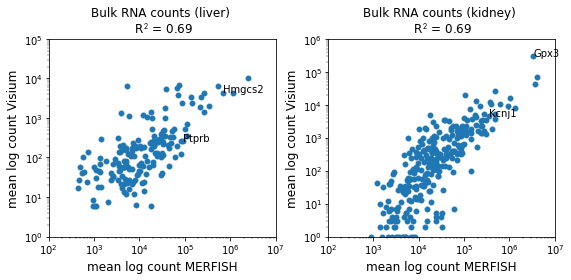

In [311]:
set_plotting_style()
# Plot the whole figure
fig, axes = plt.subplots(1,2, figsize=(8,4))

# # Panel A
# i = 0
# j = 1
# ax = axes[0,0]
# ax.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
# ax.set_xlabel('log count replicate 1')
# ax.set_ylabel('log count replicate 2')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Technical replicates (liver) \n R$^2$ = ' + str(round(R2_reps_liver,2)))

# # Panel B
# i = 0
# j = 1
# ax = axes[0,1]
# ax.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
# ax.set_xlabel('log count replicate 1')
# ax.set_ylabel('log count replicate 2')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Technical replicates (kidney) \n R$^2$ = ' + str(round(R2_reps_kidney,2)))

# Panel C
ax = axes[0]
ax.scatter(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e0,1e5))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (liver) \n R$^2$ = ' 
          + str(round(R2_compare_liver,2)))

# Annotate some genes
hmgcs2 = intersection_liver[intersection_liver['gene'] == 'hmgcs2']
ptprb = intersection_liver[intersection_liver['gene'] == 'ptprb']

ax.text(hmgcs2['Vizgen_avg'], hmgcs2['Visium_avg'], 'Hmgcs2')
ax.text(ptprb['Vizgen_avg'], ptprb['Visium_avg'], 'Ptprb')

                  
# Panel D
ax = axes[1]
ax.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e0,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (kidney) \n R$^2$ = ' 
          + str(round(R2_compare_kidney,2)))

# Annotate some genes
gpx3 = intersection_kidney[intersection_kidney['gene'] == 'gpx3']
kcnj1 = intersection_kidney[intersection_kidney['gene'] == 'kcnj1']

ax.text(gpx3['Vizgen_avg'], gpx3['Visium_avg'], 'Gpx3')
ax.text(kcnj1['Vizgen_avg'], kcnj1['Visium_avg'], 'Kcnj1')

# # Panel E
# ax = axes[2,0]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, liver')

# # Panel F
# ax = axes[2,1]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, kidney')

# Label subpanels
# axes_flat = axes.flat
# for n, ax in enumerate(axes_flat):
#     ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
#             size=20, weight='bold')

fig.tight_layout()
plt.show()

In [312]:
# Export figures
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.svg', transparent=True)
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.png', transparent=True)
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.pdf', transparent=True)

print('Figures saved.')

Figures saved.


## Digging the Visium liver dataset

- Why does this have only 9K genes?
- Do they have different gene names than MACA/MERFISH?


- (1) visium gene list - MACA gene list
- (2) vizgen gene list - MACA gene list
- (3) visium gene list - vizgen gene list
- (4) vizgen gene list - visium gene list

In [315]:
MACA

,A1_384Bulk_Plate3_S1.gencode.vM19,A11_384Bulk_Plate1_S11.gencode.vM19,A14_384Bulk_Plate3_S14.gencode.vM19,A20_384Bulk_Plate1_S20.gencode.vM19,A3_384Bulk_Plate1_S3.gencode.vM19,A6_384Bulk_Plate1_S6.gencode.vM19,A7_384Bulk_Plate3_S7.gencode.vM19,A9_384Bulk_Plate1_S9.gencode.vM19,B10_384Bulk_Plate2_S34.gencode.vM19,B12_384Bulk_Plate1_S36.gencode.vM19,...,N4_384Bulk_Plate2_S316.gencode.vM19,O1_384Bulk_Plate2_S337.gencode.vM19,O20_384Bulk_Plate2_S356.gencode.vM19,O5_384Bulk_Plate1_S341.gencode.vM19,O6_384Bulk_Plate1_S342.gencode.vM19,O7_384Bulk_Plate2_S343.gencode.vM19,P11_384Bulk_Plate2_S371.gencode.vM19,P14_384Bulk_Plate2_S374.gencode.vM19,P19_384Bulk_Plate2_S379.gencode.vM19,P9_384Bulk_Plate3_S369.gencode.vM19
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,29,6,639,11,7,2391,1599,11,0,1,...,2,15,10,24,8,3098,8,0,6,0
0610006L08Rik,7,0,0,13,4,0,0,7,0,0,...,0,0,1,4,4,5,0,0,1,0
0610009B22Rik,238,209,179,48,72,288,191,148,1,12,...,206,16,207,284,47,258,198,4,52,2
0610009E02Rik,11,1,1,6,3,22,1,12,0,0,...,0,5,9,16,1,3,5,0,1,2
0610009L18Rik,37,148,18,36,44,6,0,23,1,0,...,174,0,54,72,18,2,105,0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
__no_feature,12700679,1992095,4163811,10264072,8519434,4667548,2571333,8798034,848495,2227653,...,2396413,1664512,7050735,9035961,4502038,4373005,4816753,2109109,2395734,3311813
__ambiguous,531043,915328,893309,435566,1129927,1182617,1094543,533506,194374,275385,...,764047,543300,965331,769056,320543,1183119,530806,720545,397936,2410912
__too_low_aQual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [320]:
visium_liver.var

,gene
Mrpl15,Mrpl15
Lypla1,Lypla1
Tcea1,Tcea1
Atp6v1h,Atp6v1h
Rb1cc1,Rb1cc1
...,...
Xlr3a,Xlr3a
Zxdb,Zxdb
Armcx2,Armcx2
Trappc2,Trappc2


In [324]:

len(set(visium_liver.var_names)-set(MACA_liver["gene"]))

9655

In [347]:
set(VizgenLiver["gene"])

{'2210010c04rik',
 '4631405k08rik',
 'abcc8',
 'ace2',
 'ackr1',
 'acta2',
 'actn4',
 'adamts9',
 'adgre1',
 'adgrf5',
 'adgrl4',
 'aebp1',
 'ak4',
 'alox5ap',
 'aplp1',
 'apold1',
 'aqp1',
 'aqp2',
 'arg2',
 'arhgdib',
 'atp1b1',
 'atp1b3',
 'atp2a2',
 'bambi',
 'bank1',
 'bbox1',
 'bcl11a',
 'bcl11b',
 'bgn',
 'blk',
 'btnl9',
 'c1qa',
 'c1qb',
 'c1qc',
 'calm1',
 'cav1',
 'cavin1',
 'cavin2',
 'ccdc198',
 'ccdc80',
 'ccl6',
 'ccr2',
 'cd19',
 'cd22',
 'cd247',
 'cd300lg',
 'cd34',
 'cd37',
 'cd3d',
 'cd3e',
 'cd3g',
 'cd4',
 'cd44',
 'cd53',
 'cd5l',
 'cd6',
 'cd68',
 'cd79a',
 'cd79b',
 'cd81',
 'cd8a',
 'cd8b1',
 'cdh1',
 'cdh5',
 'cel',
 'cela1',
 'ces3a',
 'cfp',
 'chga',
 'chgb',
 'cldn3',
 'cldn5',
 'cldn7',
 'clec14a',
 'clec4f',
 'cltrn',
 'clu',
 'cnksr3',
 'col1a2',
 'col4a1',
 'col4a2',
 'colec11',
 'coro1a',
 'cpa1',
 'cpb1',
 'cpe',
 'crip2',
 'crispld2',
 'csf1r',
 'csf3r',
 'ctss',
 'ctsw',
 'cx3cr1',
 'cxcr2',
 'cxcr6',
 'cyb561a3',
 'cybb',
 'cyp2f2',
 'dag1',
 'dbp

In [352]:
visium_liver.var_names=visium_liver.var_names.str.lower()
visium_liver.var_names

Index(['mrpl15', 'lypla1', 'tcea1', 'atp6v1h', 'rb1cc1', 'pcmtd1', 'gm24276',
       'rrs1', 'adhfe1', 'vcpip1',
       ...
       'aph1b', 'gm10642', 'plscr1', 'cdcp1', 'nkrf', 'xlr3a', 'zxdb',
       'armcx2', 'trappc2', 'erdr1'],
      dtype='object', length=9655)

In [355]:

list(set(VizgenLiver["gene"])-set(visium_liver.var_names))

['cd8a',
 'ccr2',
 'bcl11a',
 'ramp3',
 'chgb',
 'h2-ab1',
 'des',
 'cd34',
 'mfap5',
 'cd3g',
 'muc4',
 'h2-aa',
 'cpa1',
 'scg2',
 'pdx1',
 'ptprn2',
 'ppp1r1a',
 'pcsk1n',
 'kcnk16',
 'mal',
 'klra2',
 'pcsk2',
 'lsp1',
 'txk',
 'sfrp5',
 'rnase6',
 'nkx6-1',
 'cd8b1',
 'pappa2',
 'tspan8',
 'klrb1f',
 'krt7',
 'bank1',
 'elane',
 'itgax',
 'gzmb',
 'cd79b',
 'neurog3',
 'cyb561a3',
 'cavin1',
 'sele',
 'fcmr',
 '4631405k08rik',
 'ms4a1',
 'krt5',
 'cd6',
 'gzmk',
 'kcnj1',
 'pnliprp2',
 'hdc',
 'ptgis',
 'mmp9',
 'scg3',
 'derl3',
 'ctsw',
 'apold1',
 'cd247',
 'cd3d',
 'trat1',
 's100a14',
 'chga',
 'klrb1c',
 'synpo',
 'cpe',
 'igfbp6',
 'foxc1',
 'cd37',
 'cd4',
 'cd79a',
 'lck',
 'pglyrp1',
 'pnliprp1',
 'il2rb',
 'jchain',
 'cd19',
 'scg5',
 'notch3',
 'wt1',
 'tlr7',
 'ccdc198',
 'g6pc2',
 'wdr72',
 'cltrn',
 'ms4a6b',
 'cldn7',
 'sox17',
 'cxcr6',
 'krt19',
 'spib',
 'adamts9',
 'slc30a8',
 'alox5ap',
 'selplg',
 'kcne1',
 'ism1',
 'aqp2',
 'cd22',
 'ace2',
 'htra3',
 'dcdc2

In [358]:
visium_liver.var_names[visium_liver.var_names.str.startswith("igb")]

Index(['igbp1'], dtype='object')

In [339]:
MACA_liver_h5ad = sc.read_h5ad("/mnt/ibm_lg/spatial-seq/MACA/TabulaMuris_1-3month_Liver_Droplet_Raw.h5ad")
MACA_liver_h5ad

AnnData object with n_obs × n_vars = 3817 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'nCount_RNA', 'nFeature_RNA'
    var: 'n_cells'

In [340]:
MACA_liver_h5ad.var_names

Index(['Xkr4', 'Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Oprk1', 'Npbwr1',
       ...
       'Ddx3y', 'Usp9y', 'Rbmy1a1', 'LOC100039753', 'Rbm31y', 'LOC434960',
       'LOC380994', 'LOC100041346', 'Sly', 'Erdr1'],
      dtype='object', name='index', length=20138)

In [343]:
list(set(visium_liver.var_names)-set(MACA_liver_h5ad.var_names))

['Mfsd4b3',
 'Mup19',
 'Cdpf1',
 'Msantd4',
 'X1810011O10Rik',
 'Urah',
 'X1110038B12Rik',
 'Faap100',
 'X2810428I15Rik',
 'Slc18b1',
 'X4932438A13Rik',
 'Primpol',
 'Fer',
 'Ndufaf7',
 'Ago1',
 'Tmem237',
 'Ntmt1',
 'Emc10',
 'Ift22',
 'Lamtor5',
 'C2cd5',
 'Nrros',
 'Inafm2',
 'Nxpe2',
 'Diaph2',
 'Gm17541',
 'Suco',
 'Ap5m1',
 'X5033403H07Rik',
 'Kat6a',
 'Vps50',
 'X2310035C23Rik',
 'Gm13775',
 'Cep104',
 'Gm11789',
 'X5730480H06Rik',
 'Supt4a',
 'X9430038I01Rik',
 'Epb41l5',
 'RP23.114A6.4',
 'Cluh',
 'Zak',
 'Diaph1',
 'X2310001H17Rik',
 'X4930581F22Rik',
 'Wfdc21',
 'P3h1',
 'Smim7',
 'Micu2',
 'Smdt1',
 'H2.D1',
 'Lamtor4',
 'Aamdc',
 'Ptrhd1',
 'Rtfdc1',
 'Fam208b',
 'Adgra3',
 'X2900026A02Rik',
 'Kyat1',
 'Etnppl',
 'Rmdn2',
 'Tmem256',
 'Flt3l.1',
 'Gm16124',
 'Lilrb4a',
 'RP24.470M22.10',
 'X4930402H24Rik',
 'Cmc4',
 'Tpgs2',
 'Wash1',
 'Cox20',
 'X2700060E02Rik',
 'X1300002E11Rik',
 'Tyw5',
 'Slc8b1',
 'X9130023H24Rik',
 'X0610030E20Rik',
 'Mvb12a',
 'Wapl',
 'Gm10320',
 '

In [359]:
VizgenLiver

,Msliver_VZG116_021121,Msliver_VZG116_021221,Msliver_VZG116_021621,Msliver_VZG116_021721,MsLiver_Cellbound_VZG116_V1_JH_09-18-2021,average,gene
0,1774.0,1472.0,801.0,4859.0,4235.0,2628.2,ptprc
1,1403.0,2475.0,1335.0,6544.0,4967.0,3344.8,pecam1
2,307.0,973.0,736.0,4583.0,18355.0,4990.8,kdr
3,748.0,1881.0,1317.0,4386.0,12254.0,4117.2,cdh5
4,12327.0,14197.0,11762.0,39666.0,3308.0,16252.0,cd19
...,...,...,...,...,...,...,...
302,108.0,256.0,174.0,647.0,1668.0,570.6,lum
303,19371.0,39894.0,18105.0,77038.0,558014.0,142484.4,serpinf1
304,2354.0,2708.0,1612.0,4851.0,1994.0,2703.8,crispld2
305,1589.0,2007.0,1272.0,3539.0,2498.0,2181.0,htra3


In [360]:
list(set(VizgenLiver["gene"])-set(MACA_liver_h5ad.var_names.str.lower()))

['adgrl4',
 'adgrf5',
 'cavin1',
 'fcmr',
 'ccdc198',
 'adgre1',
 '4631405k08rik',
 'cavin2',
 'ackr1',
 'cltrn',
 'jchain',
 'cyb561a3',
 'shisal2b']

In [363]:
# check whether the MACA dataset has specific name of the gene
MACA_liver_h5ad.var_names[MACA_liver_h5ad.var_names.str.startswith("Eltd")]

Index(['Eltd1'], dtype='object', name='index')

In [345]:
# check whether the MACA dataset has specific name of the gene
MACA_liver_h5ad.var_names[MACA_liver_h5ad.var_names.str.startswith("Als")]

Index(['Als2cr12', 'Als2cr11', 'Als2cr4', 'Als2', 'Als2cl'], dtype='object', name='index')

**Note**. visium dataset has gene names of Tmem237, which is Als2cr4 in MACA. From the gene database, Als2cr4 is a synonym of Tmem237.
- Tmem237: Als2cr4
- Adgrl4 (Vizgen): Eltd1 (MACA)

In [338]:
MACA_liver["gene"]

0                 0610005c13rik
1                 0610006l08rik
2                 0610009b22rik
3                 0610009e02rik
4                 0610009l18rik
                  ...          
54352              __no_feature
54353               __ambiguous
54354           __too_low_aqual
54355             __not_aligned
54356    __alignment_not_unique
Name: gene, Length: 54357, dtype: object

In [331]:
df_test = pd.read_csv("/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/liver/st-count/CN16_norm_CCA_D1.tsv",sep='\t')

In [332]:
df_test

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Gm24276,Rrs1,Adhfe1,Vcpip1,...,Aph1b,Gm10642,Plscr1,Cdcp1,Nkrf,Xlr3a,Zxdb,Armcx2,Trappc2,Erdr1
2x16,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2x18,0.693147,1.098612,0.0,0.693147,0.000000,0.693147,0,0.693147,0.693147,0.000000,...,0,0,0,0,0,0,0,0,0,0
2x20,0.693147,0.693147,0.0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2x22,0.693147,0.693147,0.0,0.000000,0.000000,0.000000,0,0.000000,0.693147,0.000000,...,0,0,0,0,0,0,0,0,0,0
2x24,0.000000,1.098612,0.0,0.000000,0.000000,0.000000,0,0.000000,1.098612,0.693147,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65x31,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
65x33,0.693147,1.386294,0.0,0.000000,0.693147,0.000000,0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
65x35,0.693147,1.098612,0.0,0.000000,0.000000,0.000000,0,0.000000,0.693147,0.000000,...,0,0,0,0,0,0,0,0,0,0
65x37,0.693147,0.000000,0.0,0.000000,0.000000,0.000000,0,0.000000,0.693147,0.693147,...,0,0,0,0,0,0,0,0,0,0
